In [1]:
# CONFIG CELL
from notebook_utils import set_root_directory

set_root_directory()

In [2]:
import pickle

import pandas as pd
from statsforecast import StatsForecast

from app import constants
from app.cross_validator import CrossValidator

In [3]:
INPUT_PATH = "input_files/nearest_imputed_measurements_24h_PM10.parquet"
CONFIG_PICKLE = "input_files/train_subset_config.pickle"
CV_RESULTS = "input_files/cv_results.parquet"
CV_ERRORS = "input_files/cv_errors.parquet"

CV_SPLITS = 5
FORECAST_HORIZON = 7
FREQ = "D"
MIN_DATE = "2022-01-01"
SENSOR_ID_AMOUNT = 10
YEARLY_SEASONALITY = 365

In [4]:
df = pd.read_parquet(INPUT_PATH)
df = df.rename(columns={constants.PM10: constants.Y})
df[constants.UNIQUE_ID] = df[constants.UNIQUE_ID].astype(str)
display(df.head(5))

train = df[(df[constants.TIMESTAMP_COLUMN] >= MIN_DATE)]
display(train.head(5))

,ds,unique_id,y
0,2017-01-01,182,24.968064
1,2017-01-02,182,17.943745
2,2017-01-03,182,14.477950
3,2017-01-04,182,8.418471
4,2017-01-05,182,13.189740


,ds,unique_id,y
1826,2022-01-01,182,8.744970
1827,2022-01-02,182,12.645757
1828,2022-01-03,182,11.684002
1829,2022-01-04,182,11.756574
1830,2022-01-05,182,10.160057


In [5]:
uids = train[constants.UNIQUE_ID].unique()[:SENSOR_ID_AMOUNT]
train_subset = train.query(f'{constants.UNIQUE_ID} in @uids')

In [6]:
with open(CONFIG_PICKLE, "wb") as f:
    pickle.dump(
    {
        constants.FORECAST_HORIZON: FORECAST_HORIZON,
        constants.MIN_DATE: MIN_DATE,
        constants.UIDS: uids,
    }, 
    f
)

In [7]:
display(train_subset.head(5))
display(train_subset[constants.UNIQUE_ID].unique())
display(train_subset[constants.TIMESTAMP_COLUMN].min())
display(train_subset[constants.TIMESTAMP_COLUMN].max())

,ds,unique_id,y
1826,2022-01-01,182,8.744970
1827,2022-01-02,182,12.645757
1828,2022-01-03,182,11.684002
1829,2022-01-04,182,11.756574
1830,2022-01-05,182,10.160057


array(['182', '267', '446', '999', '270', '295', '316', '695', '702',
       '744'], dtype=object)

Timestamp('2022-01-01 00:00:00')

Timestamp('2023-12-31 00:00:00')

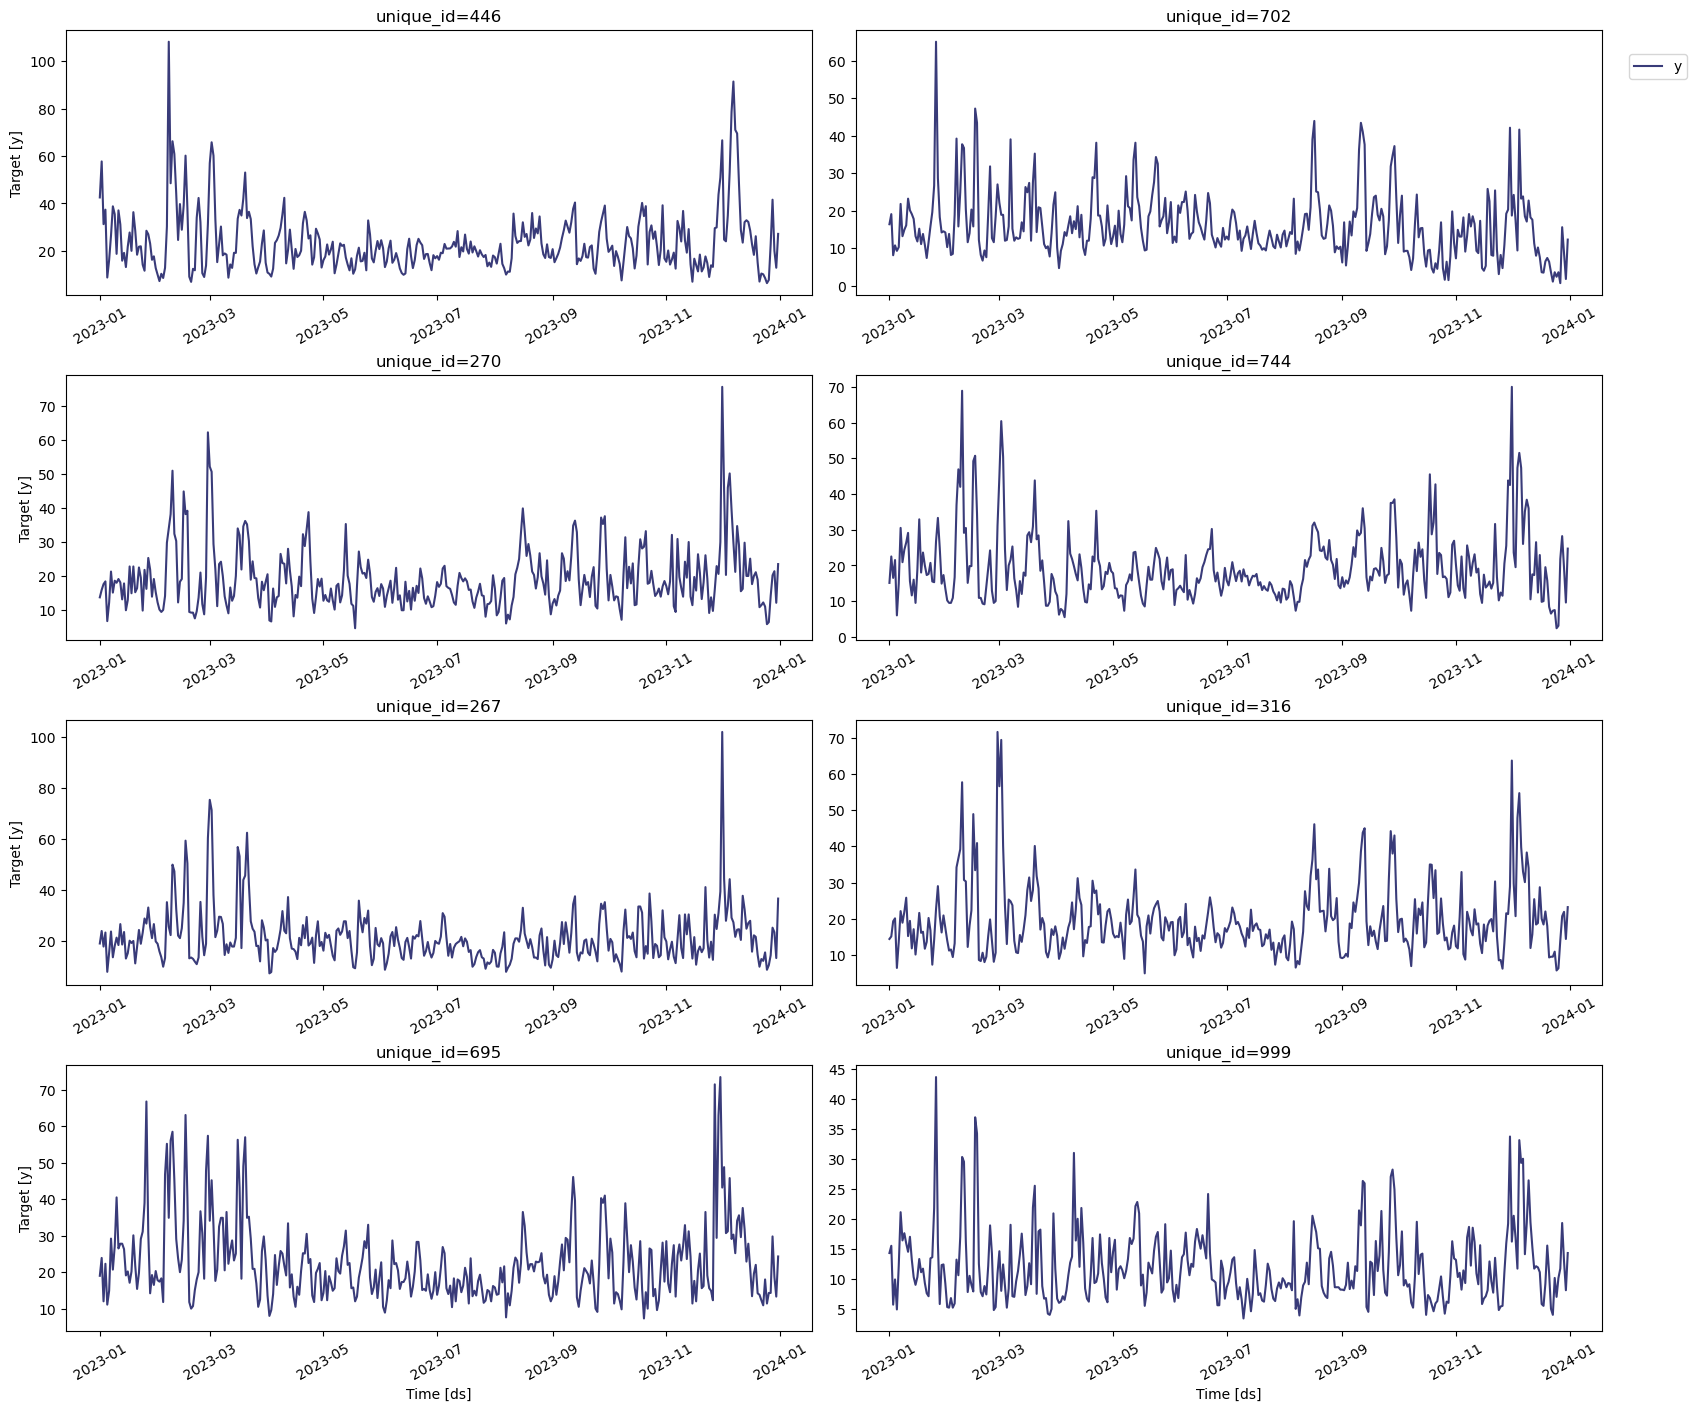

In [8]:
StatsForecast.plot(train_subset.groupby(constants.UNIQUE_ID).tail(YEARLY_SEASONALITY))

In [9]:
cv = CrossValidator(
    models=[constants.MODEL_AUTO_ARIMA_365, constants.MODEL_AUTO_ETS_365, constants.MODEL_HISTORIC_AVERAGE],
    freq=FREQ,
    forecast_horizon=FORECAST_HORIZON,
    season_length=YEARLY_SEASONALITY,
    cv_folds=CV_SPLITS,
    metric=constants.MAE,
    n_jobs=-1,
    verbose=True
)

In [10]:
cv_result = cv.fit_transform(train_subset)

c:\Users\Mambo\Desktop\moje_AGH\staszel\daes-project-2425-ispies\app\cross_validator.py:187: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cv_df_results = cv_df_grouped.apply(


In [11]:
cv_result.to_parquet(CV_RESULTS, index=False)
cv.error_df.to_parquet(CV_ERRORS, index=False)